In [337]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [338]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
targetimage = train_X[0]

One of the ideas I thought about was making image compression achievable only by using linear regression. Image compression is very tricky as much of the represented data doesn't have an obvious distribution. However, there are patterns in most images. In fact, it turns out that most images can be represented by using additions of sine functions. Let's show how images look in a graph first. 

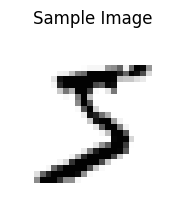

In [339]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [340]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

targetimage = feature_scale(targetimage, scaled=True)

In [341]:
targetimage = targetimage.flatten().astype(np.float64)
pixels = len(targetimage)
xcoordinates = np.arange(0, pixels).astype(np.float64)

Here for our features, we only use a single feature which is the coordinate of the image. Of course in an image, there are 2 coordinates, To solve this we simplify flatten the image to a 1-D array and we get 1 coordinate. Also the range of $x$ values are between 0 and 1, but in practice the range doesn't matter at all. We also use min max normalization to put image between 0 and 1. 

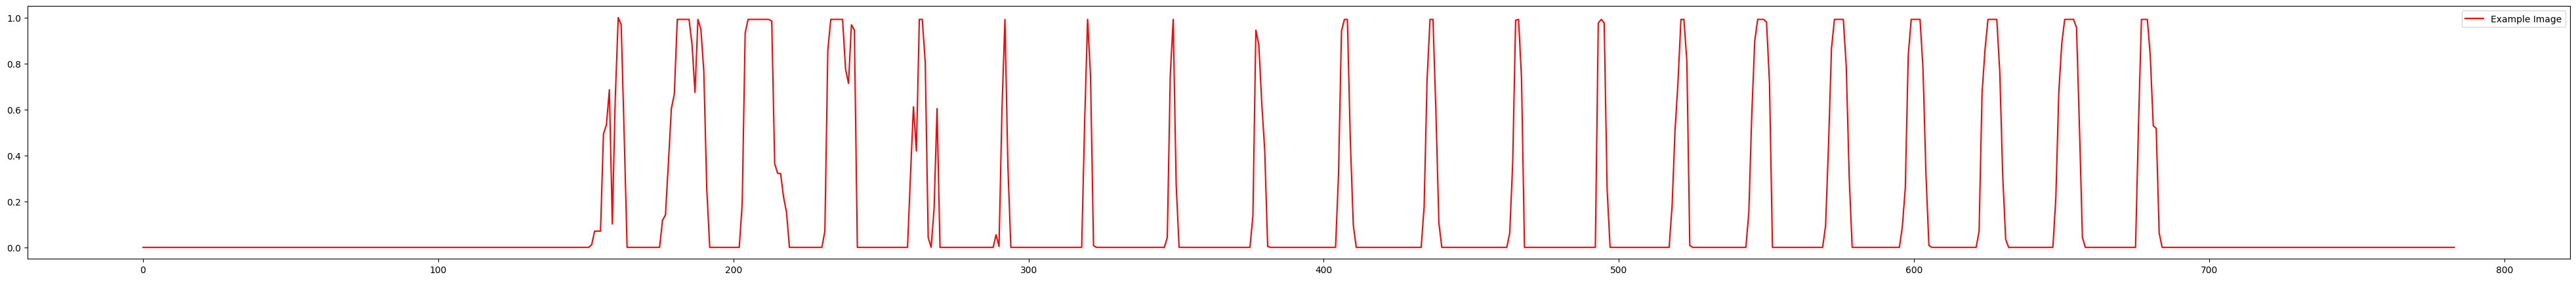

In [356]:
fig,ax = plt.subplots(figsize=(50,5))
ax.plot(xcoordinates.flatten(), targetimage, color="r",label="Example Image")
ax.legend()

Looking at this, it's clear why using sine waves are a good idea. Of course, I only showed one image, but you can show this pattern for most images as well. From this, we need to design a single function that best represents the image. The idea for this is that if the function weights are learned properly, then we only need the weights to store as data which is significantly smaller than the data in image space. Therefore, we achieve some basic compression as a result. Next step is to formalize this function. 

One important thing about adding sine functions together is to decide how many functions to add. To simplify, I'll only use 2 sine functions and derive the cost function and gradients from there. Then, the full general $n$ functions can be derived easily from there. $$ f(x)=A\sin(Bx+C) + D\sin(Ex+F) $$ Here, there are many weights here that can control the sine function to the fullest. Even with two functions, if you play around with the weights, the function can represent some complex sinusoid patterns. Here is a desmos graph showing the full power. https://www.desmos.com/calculator/h9kqrl4pux. Of course, we also don't need cosine functions as the weights can also represent the cosine wave easily. You can also observe I didn't use the bias term in the function as this will keep implementation easier for now.

Some background on waves. $ f(x)=A\sin(Bx+C) $. If we have a single wave like this, the $A$ represents the amplitude of the function, the $B$ shows the frequency of the function. And the $C$ is the phase of the function. This is important to understand so that the code will make sense soon enough. Next step is to decide the the format of the weights. From some thinking, I figured out that it was best to use duplicated weight matrices and to also separate the weight matrices in 3 groups. These 3 groups are amplitude, frequency and phase. From our earlier 2 sine functions, the amplitude weights would be $[A,D]$, the frequency weights would be $[B,E]$, the phase weights would be $[C,F]$. Of course, these are vectors and we ignored the different coordinates to consider. So by taking in different coordinates into consideration, we get 
$$ 
  W1 =
  \left[ {\begin{array}{cc}
    A & D \\
    A & D \\
  \end{array} } \right]
$$
Here, the different weights are duplicated across each row. Each row denotes a single coordinate or the training example in machine learning standards. Here, I only showed for 2 coordinates. Similar matrices can be derived for the other 2 components of the wave. 
$$ 
  W_2 =
  \left[ {\begin{array}{cc}
    B & E \\
    B & E \\
  \end{array} } \right]
,
  W_3 =
  \left[ {\begin{array}{cc}
    C & F \\
    C & F \\
  \end{array} } \right]
$$
We also do a similar thing for the X coordinates (X features) as well. 
$$ 
  X =
  \left[ {\begin{array}{cc}
    x_1 & x_1 \\
    x_2 & x_2 \\
  \end{array} } \right]
$$
This data format looks odd, but trust me it will make the code so much easier to write. From this, the prediction function is really obvious with this format. $$ f(x) = W_1 * \sin(X*W_2+W_3) $$ Note that all the multiplications between the matrices are hadamard products, they aren't matrix multiplications. From this we add up the sine functions along each row of values to get the vector of predictions we desire. 

In [342]:
def predict(x, ampweights, periodweights, horizonalweights, wave_samples, epsilon=1e-15): # all are vectors
    coordinates = len(x)
    xmat = np.repeat(x, wave_samples).reshape((-1, wave_samples))
    ampweightsmat = np.tile(ampweights, coordinates).reshape((coordinates, -1))
    periodweightsmat = np.tile(periodweights, coordinates).reshape((coordinates, -1))
    horizonalweightsmat = np.tile(horizonalweights, coordinates).reshape((coordinates, -1))
    
    combined_waves = ampweightsmat * np.sin(xmat * periodweightsmat + horizonalweightsmat)
    summed_waves = np.sum(combined_waves,axis=1)

    return summed_waves # vector

Here, since we're taking in only vectors all the repeats and retiles shape the vectors into the matrix format we need. Then, the actual prediction is simple as it directly translates from math to code. Also, using matrices is a good idea as we don't need a loop for the amount of wave samples we have. Then, at the end we just add up each sine function term along the respective axis and get a vector of predictions for all the coordinates. 

In [343]:
def inference(x, ampweights, periodweights, horizonalweights, wave_samples):
    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    return np.clip(prediction, 0.0, 1.0)

Inference is the same here as prediction. We also make sure to clip the values to make sure they stay between 0 and 1. 

In [344]:
def mse_cost(x, y, ampweights, periodweights, horizonalweights, wave_samples):
    coordinates = len(x)
    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    error = prediction - y

    return np.dot(error, error) / (2*coordinates)

Even the MSE cost function doesn't change at all. This is the exact same we have with normal linear regression. 

In [345]:
def compute_gradients(x, y, ampweights, periodweights, horizonalweights, wave_samples):
    coordinates = len(x)
    xmat = np.repeat(x, wave_samples).reshape((-1, wave_samples))
    ampweightsmat = np.tile(ampweights, coordinates).reshape((coordinates, -1))
    periodweightsmat = np.tile(periodweights, coordinates).reshape((coordinates, -1))
    horizonalweightsmat = np.tile(horizonalweights, coordinates).reshape((coordinates, -1))
    
    amp_partials =  np.sin(xmat * periodweightsmat + horizonalweightsmat)
    period_partials = xmat * ampweightsmat * np.cos(xmat * periodweightsmat + horizonalweightsmat)
    horizonal_partials = ampweightsmat * np.cos(xmat * periodweightsmat + horizonalweightsmat)

    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    error = prediction - y
    errorT = error.reshape((-1,1))

    daw = np.sum(errorT * amp_partials, axis=0) / coordinates
    dpw = np.sum(errorT * period_partials, axis=0) / coordinates
    dhw = np.sum(errorT * horizonal_partials, axis=0) / coordinates

    return daw, dpw, dhw

For the gradient function, we have to rederive the cost function $J$ partials with respect to each weight. Now, there is such a thing as matrix calculus which would help here, but I decided to go another route instead by only deriving each weight of the 1st sine function and then generalizing it to all of the functions. Also, we only need to rederive the new prediction function instead of the full mse cost function as the chain rule will save us time here. With this function $f(x)=A\sin(Bx+C)$, taking the partials along $A$, $B$ and $C$ gives us $$ \frac{\partial J}{\partial A} = \sin(Bx+C) $$ $$ \frac{\partial J}{\partial B} = Ax\cos(Bx+C) $$ $$ \frac{\partial J}{\partial C} = A\cos(Bx+C) $$ From this, all of the other weights are the exact same partials above. In fact, we can just use the weight matrices we have to compute the gradient easily. In the code above, we directly translate the math to code just like the prediction function but with the partials, we also get the prediction and error and use the chain rule for the MSE with np.sum which will get us the 3 different weight gradient matrices we can use for gradient descent.

In [346]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Epoch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

Now, we do gradient descent and hope for the best

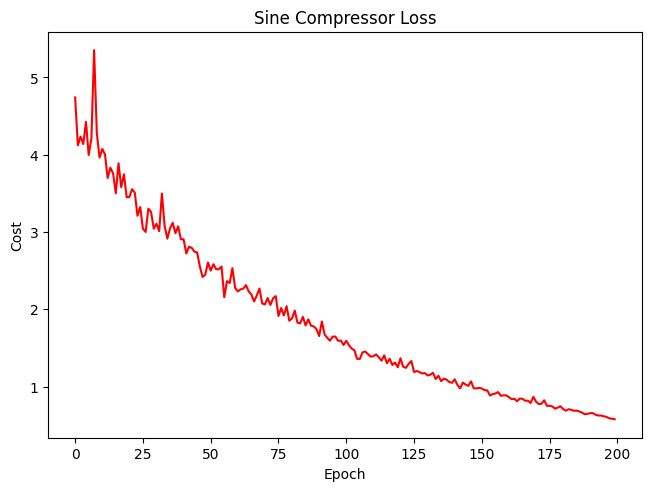

In [347]:
def gradient_descent(x, y, gradient_func, cost_func, wave_samples, learning_rate=0.01, max_iterations=1000):
    ampweights = np.random.random(wave_samples)
    periodweights = np.random.random(wave_samples)
    horizonalweights = np.random.random(wave_samples)
    
    costs = np.empty(0)

    for _ in range(max_iterations):
        daw,dpw,dhw = gradient_func(x, y, ampweights, periodweights, horizonalweights, wave_samples)

        ampweights -= learning_rate * daw
        periodweights -= learning_rate * dpw
        horizonalweights -= learning_rate * dhw
        
        current_cost = cost_func(x, y, ampweights, periodweights, horizonalweights, wave_samples)
        costs = np.append(costs, current_cost)
    return ampweights, periodweights, horizonalweights, costs
wave_samples = 50 # define the number of samples we will use. another hyper
ampweights, periodweights, horizonalweights, costs = gradient_descent(xcoordinates, targetimage, compute_gradients, mse_cost, wave_samples=wave_samples, learning_rate=0.01, max_iterations=200)
show_cost_graph(costs, "Sine Compressor Loss", "red")

Cost function is really bad. It spikes up and down randomly but still decreases overall. This shows us that the cost function isn't convex and gradient descent could easily get stuck on a bad local minima. I also thought of using the cross entropy loss next. However, from online googling, it turns out that no cost function is convex with sinusoids as the prediction function. 

In [348]:
print("Initial cost", costs[0])
print("Final cost", costs[-1])

Initial cost 4.741034092212496
Final cost 0.5770544720723736


In [349]:
predicted_image = inference(xcoordinates, ampweights, periodweights, horizonalweights, wave_samples)

Here, we can also try to show the image after compression and decompression.

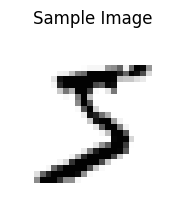

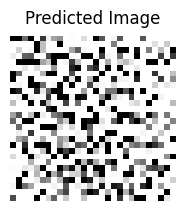

In [358]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image")
plt.show()

As expected, gradient descent didn't work and get us to the bottom we needed. Using sum of sine waves as regression doesn't work as the cost function isn't exactly convex. In fact, after some research, there is no easy way to use a convex version for the cost function. So this is why it can't represent the full image. From more searching, it seems the best approach is to use FFT. However, I don't like the FFT as it's math heavy. Another approach that might work is to use fourier series as feature engineering and linear regression to achieve image compression instead of the FFT. 